In [31]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

## analysis imports
from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class
from fund.fund import Fund

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [32]:
backtest_start_date = datetime(2003,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [33]:
market = Market()

In [34]:
portfolio = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_iv = APortfolio(pricer_list.WEEKLY_CRYPTO_ROLLING
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_v = APortfolio(pricer_list.WEEKLY_CRYPTO_WINDOW
                          ,classifier_list.NONE
                          ,ranker_list.NONE)
portfolio_vi = APortfolio(pricer_list.WEEKLY_CRYPTO_SPECULATION
                          ,classifier_list.NONE
                          ,ranker_list.NONE)

portfolios = []
portfolios.append(portfolio)
portfolios.append(portfolio_ii)
portfolios.append(portfolio_iii)
portfolios.append(portfolio_iv)
portfolios.append(portfolio_v)
portfolios.append(portfolio_vi)

In [35]:
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
market = Market()
fund.initialize_portfolios()

In [36]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [37]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields"))
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()

In [38]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    try:
        trade = portfolio.db.retrieve("trades")
        trade["positions"] = int(portfolio.pricer_class.positions / 5) if portfolio.pricer_class.asset_class.value == "stocks" else 1
        trade["portfolio"] = portfolio.name
        trade = trade[trade["position"] <= int(portfolio.pricer_class.positions / 5)]
        trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
        trades.append(trade)
    except Exception as e:
        print(str(e))
        continue
    portfolio.db.disconnect()

'position'
'position'
'position'
'position'
'position'


In [39]:
t = pd.concat(trades)
t = t[(t["year"]>=backtest_start_date.year) & (t["year"]<backtest_end_date.year)]

In [40]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [41]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [42]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'market_return',
 'buy_day',
 'sell_day',
 'risk',
 'floor_value',
 'tyields',
 'portfolio',
 'pricer_timeframe']

In [43]:
analysis = []
for parameter in tqdm(parameters):
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(int(ledger["positions"].mean()))
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.32it/s]


In [44]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,tyields,portfolio,pricer_timeframe,pv,beta,rrr,sharpe
955,True,True,False,False,False,1.15,1,5,rrr,0.5,tyields,wss_n_n_b_r,week,14.426036,-0.069734,0.913283,-192.527358
953,True,True,False,False,False,1.15,1,5,flat,0.5,tyields10,wss_n_n_b_r,week,11.384786,-0.067031,0.916692,-154.920493
953,True,True,False,False,False,1.15,1,5,flat,0.5,tyields,wss_n_n_b_r,week,11.384786,-0.067031,0.916692,-154.920493
953,True,True,False,False,False,1.15,1,5,flat,1.0,tyields,wss_n_n_b_r,week,11.175043,-0.069436,0.913690,-146.532845
953,True,True,False,False,False,1.15,1,5,flat,1.0,tyields10,wss_n_n_b_r,week,11.175043,-0.069436,0.913690,-146.532845


In [45]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,market_return,buy_day,sell_day,risk,floor_value,tyields,pricer_timeframe,pv,beta,rrr,sharpe
0,wss_n_n_b_r,True,True,False,False,False,1.15,1,5,rrr,0.5,tyields,week,14.426036,-0.069734,0.913283,-192.527358


In [46]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
positions = int(int(analysis["positions"].mean()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[ledger["year"]>=backtest_start_date.year]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

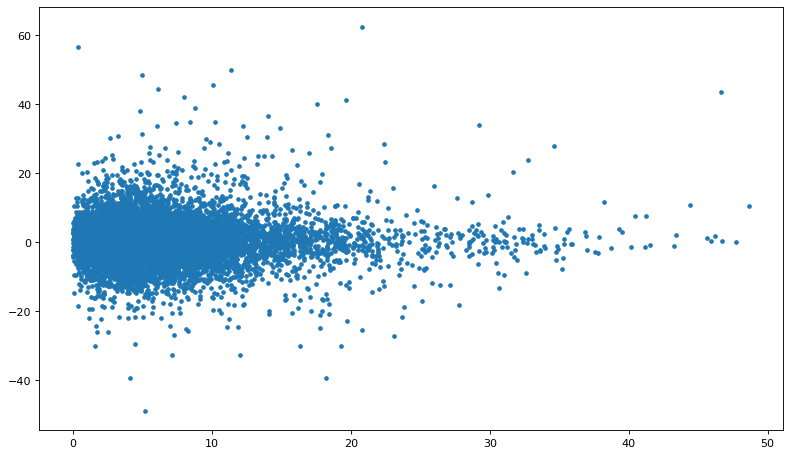

In [47]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [48]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2003,5,ABMD,0.131069,1.0,0.952849,0,Health Care,Abiomed
956,2003,5,BDX,0.043588,1.0,0.951671,1,Health Care,Becton Dickinson
1910,2003,5,PTC,0.039568,1.0,0.945833,2,Information Technology,PTC
2864,2003,5,FCX,0.018587,1.0,1.012273,3,Materials,Freeport-McMoRan
3815,2003,5,RMD,0.014746,1.0,1.023411,4,Health Care,ResMed
4764,2003,5,J,0.011867,1.0,1.005442,5,Industrials,Jacobs Engineering Group
5713,2003,5,IDXX,0.004632,1.0,1.008605,6,Health Care,Idexx Laboratories
6661,2003,5,NEM,0.003383,1.0,1.011202,7,Materials,Newmont
7605,2003,5,WYNN,0.003218,1.0,0.952314,8,Consumer Discretionary,Wynn Resorts
8546,2003,5,NFLX,0.002539,1.0,0.980080,9,Communication Services,Netflix


In [49]:
ledger["actual_returns"].mean()

1.0037361401975422

In [50]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5410805300713558

In [51]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [52]:
positions

20

In [53]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [54]:
cumulative.head(50)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
0,0.952849,0.951671,0.945833,1.012273,1.023411,1.005442,1.008605,1.011202,0.952314,0.980080,...,1.000000,1.000000,1.000000,2003,5,0.992184,878.680008,1.000000,2003-W5,2003-01-31
1,0.943463,0.897289,1.061107,0.996342,0.920759,0.969079,1.057864,0.986071,0.928278,0.821334,...,0.968007,0.985642,0.970210,2003,6,0.965586,854.137988,0.972069,2003-W6,2003-02-07
2,0.928368,0.916711,1.101357,1.054288,0.953710,1.004300,1.047603,0.999391,0.948282,0.808389,...,0.954507,0.967451,0.996888,2003,7,0.972693,843.990014,0.960520,2003-W7,2003-02-14
3,0.927734,0.914125,1.089655,1.089788,0.974227,1.038826,1.047603,1.082347,0.975463,0.822589,...,0.981717,0.988636,0.982491,2003,8,0.975150,827.221997,0.941437,2003-W8,2003-02-21
4,0.933063,0.952144,1.065174,1.100244,0.979701,1.032153,1.015778,1.060581,0.947648,0.823809,...,0.894498,1.058108,0.981060,2003,9,0.970637,845.392487,0.962116,2003-W9,2003-02-28
5,0.910269,0.902644,1.080724,1.133542,0.957397,0.986032,0.974920,1.054638,0.933597,0.778769,...,0.928288,1.152958,0.894678,2003,10,0.948870,835.426013,0.950774,2003-W10,2003-03-07
6,1.029151,1.023141,1.338512,1.244161,1.050161,1.192781,1.028284,1.108581,1.091975,0.788293,...,1.046804,1.191268,0.932448,2003,11,1.042336,827.527991,0.941785,2003-W11,2003-03-14
7,1.453676,1.027726,1.114137,1.225729,1.054551,1.224589,0.986597,1.126788,1.086537,0.778595,...,1.087927,1.192518,0.911762,2003,12,1.053421,815.514001,0.928113,2003-W12,2003-03-21
8,1.584835,1.026209,1.200148,1.291797,1.053178,1.291760,0.969788,1.137345,1.113200,0.747822,...,1.119282,1.139339,0.890317,2003,13,1.065373,874.943994,0.995748,2003-W13,2003-03-28
9,1.686813,1.128830,1.209436,1.345250,1.029811,1.302644,0.951175,1.101830,1.113200,0.745010,...,1.124217,1.147988,0.899201,2003,14,1.092971,868.188000,0.988059,2003-W14,2003-04-04


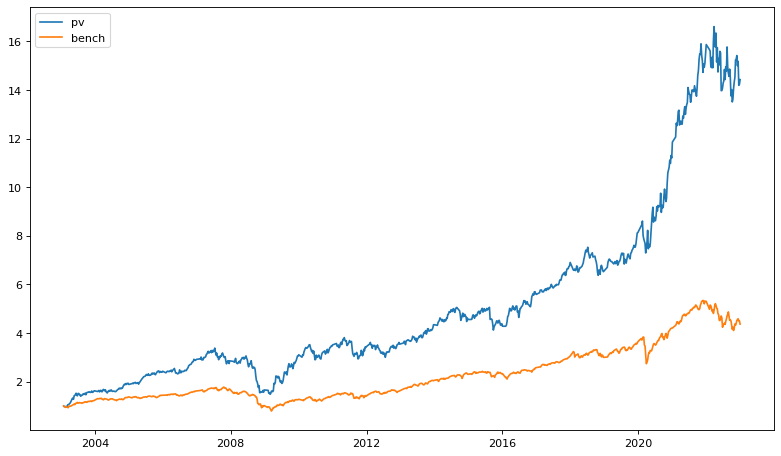

In [55]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [56]:
cumulative.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,year,week,pv,adjclose,bench,date_string,date
936,1.778141,7.167464,8.595118,6.539406,34.540904,13.339735,10.700571,29.058547,11.581894,4.543964,...,20.083851,3.763611,17.104359,2022,33,14.946132,4192.04,4.770838,2022-W33,2022-08-19
937,1.758889,7.091744,8.551658,6.381659,33.107024,13.379345,10.707600,29.140540,11.717140,4.456588,...,19.642952,3.674465,16.666844,2022,34,14.690474,4277.72,4.868348,2022-W34,2022-08-26
938,1.749148,6.613791,8.260347,6.574064,34.733027,13.034139,10.307199,29.027399,11.453136,4.267251,...,19.658297,3.532660,16.553154,2022,35,14.560025,4132.85,4.703476,2022-W35,2022-09-02
939,1.823354,6.826735,8.133776,6.320597,35.179874,13.156384,10.404846,30.504831,12.348311,4.411344,...,20.429744,3.641504,17.266107,2022,36,14.858715,3972.58,4.521077,2022-W36,2022-09-09
940,1.821821,5.915590,8.667971,6.112617,33.628897,12.614021,10.587743,30.280943,11.606592,4.250293,...,19.228130,3.426512,16.727530,2022,37,14.502989,3990.40,4.541357,2022-W37,2022-09-16
941,1.680768,5.678678,8.494719,5.923243,30.807831,11.990446,10.224300,29.366607,10.901710,3.956929,...,18.715455,3.117629,15.473436,2022,38,13.755697,3952.76,4.498520,2022-W38,2022-09-23
942,1.692193,5.958224,9.027226,6.133922,32.668580,12.617083,10.526962,30.745652,10.901710,3.956929,...,18.715455,3.117629,15.473436,2022,39,14.015860,3799.39,4.323975,2022-W39,2022-09-30
943,1.632282,5.459099,8.557975,6.110787,31.034235,12.188249,9.735699,29.521192,10.319966,3.691406,...,18.297028,2.870422,14.785656,2022,40,13.508517,3649.49,4.153378,2022-W40,2022-10-07
944,1.660102,5.807397,8.959154,5.988971,32.260144,12.729303,9.767332,29.521192,10.319966,3.691406,...,18.297028,2.870422,14.785656,2022,41,13.631220,3727.36,4.241999,2022-W41,2022-10-14
945,1.754292,6.049372,9.211641,7.236196,32.731838,13.142759,9.904624,30.067188,10.253633,3.728708,...,19.771475,3.098346,14.492127,2022,42,14.059818,3606.25,4.104168,2022-W42,2022-10-21


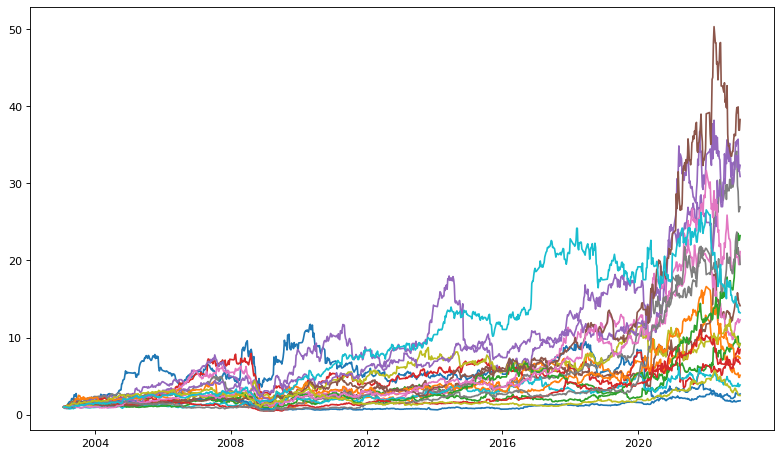

In [57]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [58]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Real Estate,2011.694343,27.896898,0.044188,1.0,1.005831,11.408759
Communication Services,2013.280392,29.094118,0.051344,1.0,1.004547,9.423529
Information Technology,2012.755979,28.601810,0.054594,1.0,1.004464,9.829670
Health Care,2012.212601,28.894472,0.049222,1.0,1.004461,9.664863
Consumer Discretionary,2012.945283,28.594609,0.074143,1.0,1.004315,8.115364
Materials,2012.769543,27.806091,0.048439,1.0,1.004175,10.686294
Consumer Staples,2012.363434,28.197324,0.036537,1.0,1.003262,10.777035
Industrials,2011.856324,28.333186,0.048014,1.0,1.002988,10.717497
Energy,2013.541998,28.418214,0.052336,1.0,1.002554,10.150309


In [59]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  weekly_delta_sign  \
year week ticker Security                                                    
2009 18   LVS    Las Vegas Sands               0.208342                1.0   
2020 5    TSLA   Tesla, Inc.                   0.003217                1.0   
2013 19   TSLA   Tesla, Inc.                   0.113933                1.0   
2006 39   ALGN   Align Technology              0.049290                1.0   
2009 18   CBRE   CBRE Group                    0.100423                1.0   
2020 7    ENPH   Enphase                       0.060833                1.0   
2009 15   MGM    MGM Resorts                   0.466725                1.0   
     37   MGM    MGM Resorts                   0.080014                1.0   
2003 12   SBAC   SBA Communications            0.196584                1.0   
2008 32   AAL    American Airlines Group       0.175341                1.0   
2009 37   UAL    United Airlines Holdings      0.087592                1.0   
2007 17   ALGN   Align Technology              0.048232                1.0   
2020 21   PENN   Penn National Gaming          0.140409                1.0   
2008 16   DXCM   Dexcom                        0.102376                1.0   
2022 11   EPAM   EPAM Systems                  0.084177                1.0   
2011 44   ABMD   Abiomed                       0.074394                1.0   
2003 21   REGN   Regeneron                     0.292459                1.0   
2020 20   PENN   Penn National Gaming          0.122029                1.0   
2006 42   CNC    Centene Corporation           0.060058                1.0   
2009 16   HBAN   Huntington National Bank      0.148634                1.0   
2003 27   SBAC   SBA Communications            0.049440                1.0   
2009 19   COF    Capital One                   0.183360                1.0   
2021 28   MRNA   Moderna                       0.031984                1.0   
2009 15   HST    Host Hotels & Resorts         0.125181                1.0   
     18   IP     International Paper           0.139925                1.0   
2020 35   CRM    Salesforce                    0.026422                1.0   
2008 32   UAL    United Airlines Holdings      0.095620                1.0   
2009 30   INCY   Incyte                        0.098776                1.0   
2003 16   PTC    PTC                           0.105379                1.0   
     21   ISRG   Intuitive Surgical            0.223790                1.0   

                                           actual_returns  position  
year week ticker Security                                            
2009 18   LVS    Las Vegas Sands                 1.624642         2  
2020 5    TSLA   Tesla, Inc.                     1.564756        17  
2013 19   TSLA   Tesla, Inc.                     1.499550         1  
2006 39   ALGN   Align Technology                1.483660         8  
2009 18   CBRE   CBRE Group                      1.455128        17  
2020 7    ENPH   Enphase                         1.442763         2  
2009 15   MGM    MGM Resorts                     1.435955         0  
     37   MGM    MGM Resorts                     1.420829         8  
2003 12   SBAC   SBA Communications              1.412500         0  
2008 32   AAL    American Airlines Group         1.401493         1  
2009 37   UAL    United Airlines Holdings        1.388626         6  
2007 17   ALGN   Align Technology                1.380705         3  
2020 21   PENN   Penn National Gaming            1.364939        11  
2008 16   DXCM   Dexcom                          1.348968         0  
2022 11   EPAM   EPAM Systems                    1.348827         2  
2011 44   ABMD   Abiomed                         1.346127         5  
2003 21   REGN   Regeneron                       1.339339         0  
2020 20   PENN   Penn National Gaming            1.336901         5  
2006 42   CNC    Centene Corporation             1.336032        12  
2009 16   HBAN   Huntington National Bank        1.332046        20  
2003 2

In [60]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2003,5,0.980080,0.952314,1.000000,1.000000,1.000000,0.984134,1.005442,0.945833,1.011737,1.000000,1.000000
1,4012009,30,0.935281,0.921847,1.000000,0.977926,0.923492,1.068136,0.990227,0.945833,1.011737,0.942857,0.899691
2,8036054027,210,0.935281,0.907098,1.000000,0.968441,0.923492,1.019475,1.004681,0.987204,1.039558,0.953609,0.887143
3,16096216216081,1680,0.934643,0.918096,1.000000,0.968441,0.928185,1.001428,1.016596,0.987551,1.039558,0.920389,0.912570
4,32240721080810243,15120,0.934643,0.896985,0.984981,0.975466,0.933287,1.011824,1.004073,0.981207,1.018652,0.955313,0.894689
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0,0,14.361320,13.711673,7.121034,3.652449,3.902305,82.688736,15.410588,52.727594,12.941625,12.457267,1.172891
952,0,0,14.826224,13.994272,7.211514,3.652449,3.962404,83.111942,14.989246,52.454040,12.941625,12.462721,1.172891
953,0,0,12.687208,12.990447,7.052892,3.652449,3.799679,78.511826,14.207174,47.897248,12.941625,12.462721,1.132677
954,0,0,12.787356,13.059480,7.052892,3.652449,3.853125,79.980320,14.213965,47.536273,12.941625,12.462721,1.132677
